#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [6]:
file1 = 'data03.pkl'
product_3 = joblib.load(path + file1)

In [7]:
file2 = 'data12.pkl'
product_12 = joblib.load(path + file2)

In [8]:
file3 = 'data42.pkl'
product_42 = joblib.load(path + file3)

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [9]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [10]:
def pre3d(data, timesteps, y_scale=False, target_col='Qty_2days_later'):

    x = data.drop(columns=[target_col], axis=1)
    y = data[target_col]

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 데이터 시계열화 (3차원 변환)
    x3, y3 = temporalize(x_scaled, y, timesteps)

    # 데이터 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=60, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max


## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [11]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1080, 7, 13), (60, 7, 13))

* **모델링**

In [12]:
clear_session()

_, ts, nfeat = x_train.shape

model_p3_lstm = Sequential([LSTM(16, input_shape = (ts, nfeat), return_sequences = True ),
                         LSTM(4, return_sequences = True),
                         Flatten(),
                         Dense(16, activation = 'relu'),
                         Dense(1)])
model_p3_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 16)               │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 4)                │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,737 (10.69 KB)

 Trainable params: 2,737 (10.69 KB)

 Non-trainable params: 0 (0.00 B)

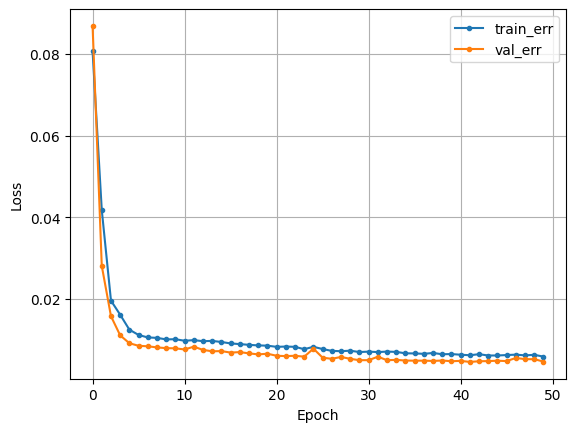

In [13]:
model_p3_lstm.compile(optimizer = 'adam', loss = 'mse')
hist = model_p3_lstm.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [14]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p3_lstm.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MAE :  1895.4772379557292
MAPE :  0.16338190826632162
R2 :  0.5303431068889284


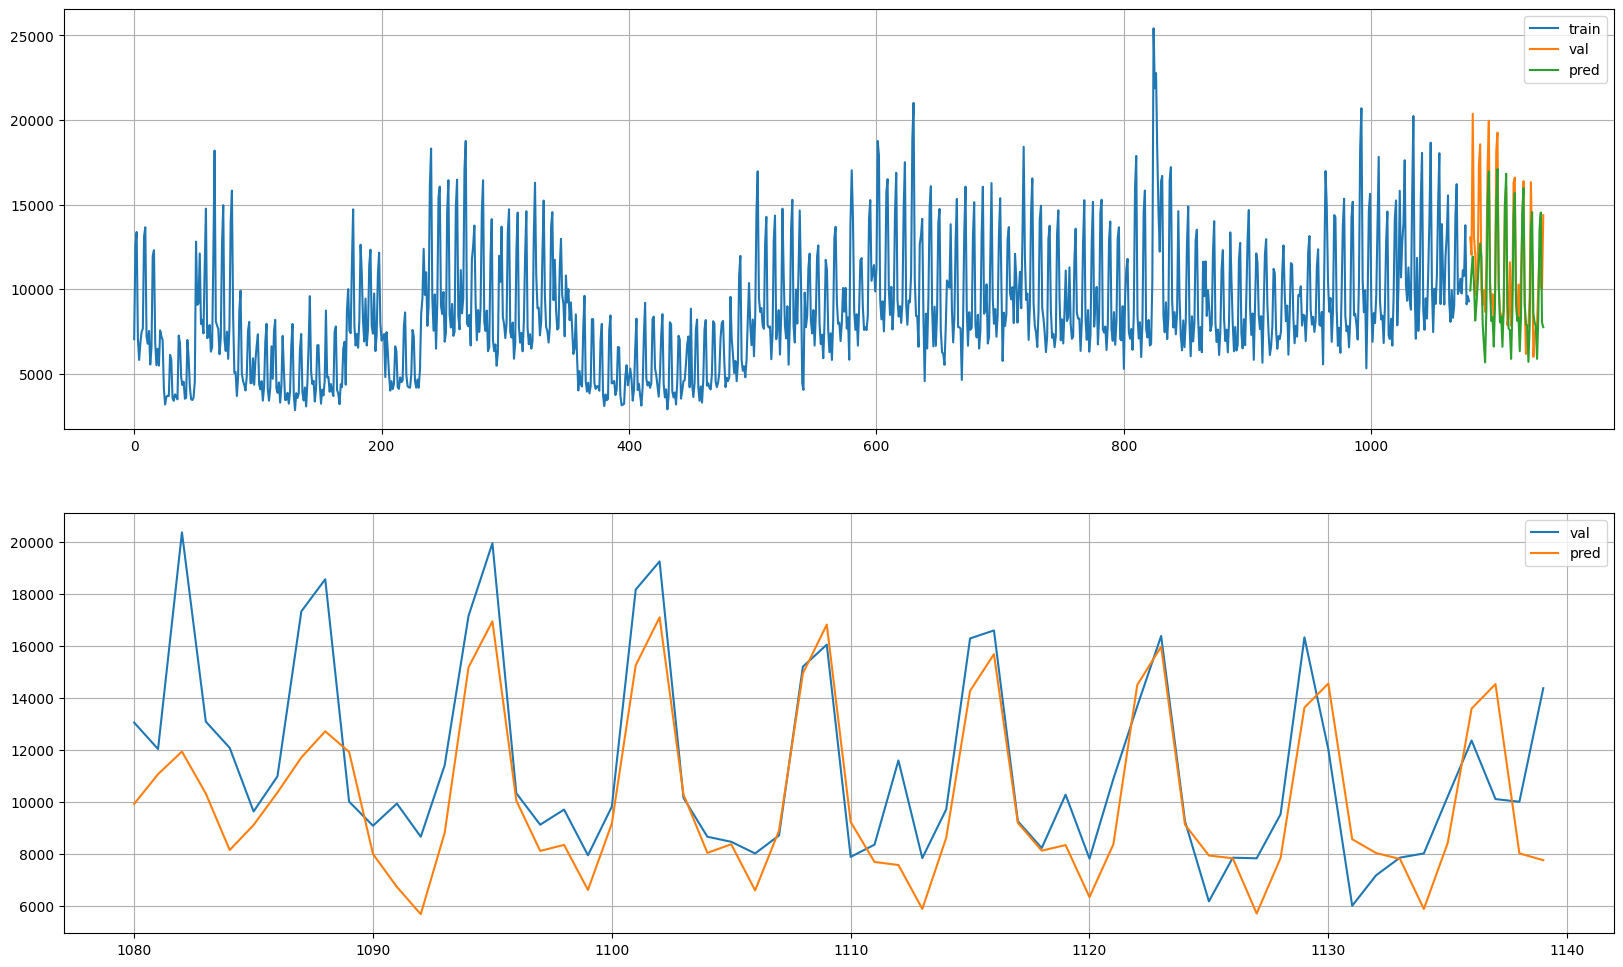

In [15]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [16]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1080, 7, 8), (60, 7, 8))

* **모델링**

In [17]:
clear_session()

_, ts, nfeat = x_train.shape

model_p12_lstm = Sequential([LSTM(16, input_shape = (ts, nfeat), return_sequences = True ),
                         LSTM(4, return_sequences = True),
                         Flatten(),
                         Dense(16, activation = 'relu'),
                         Dense(1)])
model_p12_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 16)               │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 4)                │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,417 (9.44 KB)

 Trainable params: 2,417 (9.44 KB)

 Non-trainable params: 0 (0.00 B)

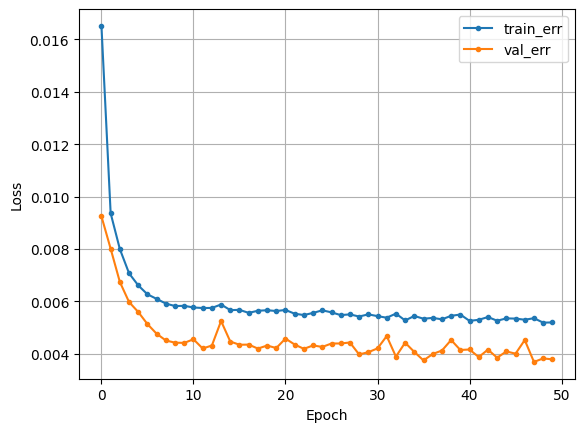

In [18]:
model_p12_lstm.compile(optimizer = 'adam', loss = 'mse')
hist = model_p12_lstm.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [19]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p12_lstm.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
MAE :  1599.4966145833334
MAPE :  0.1367517449569104
R2 :  0.5767185762962155


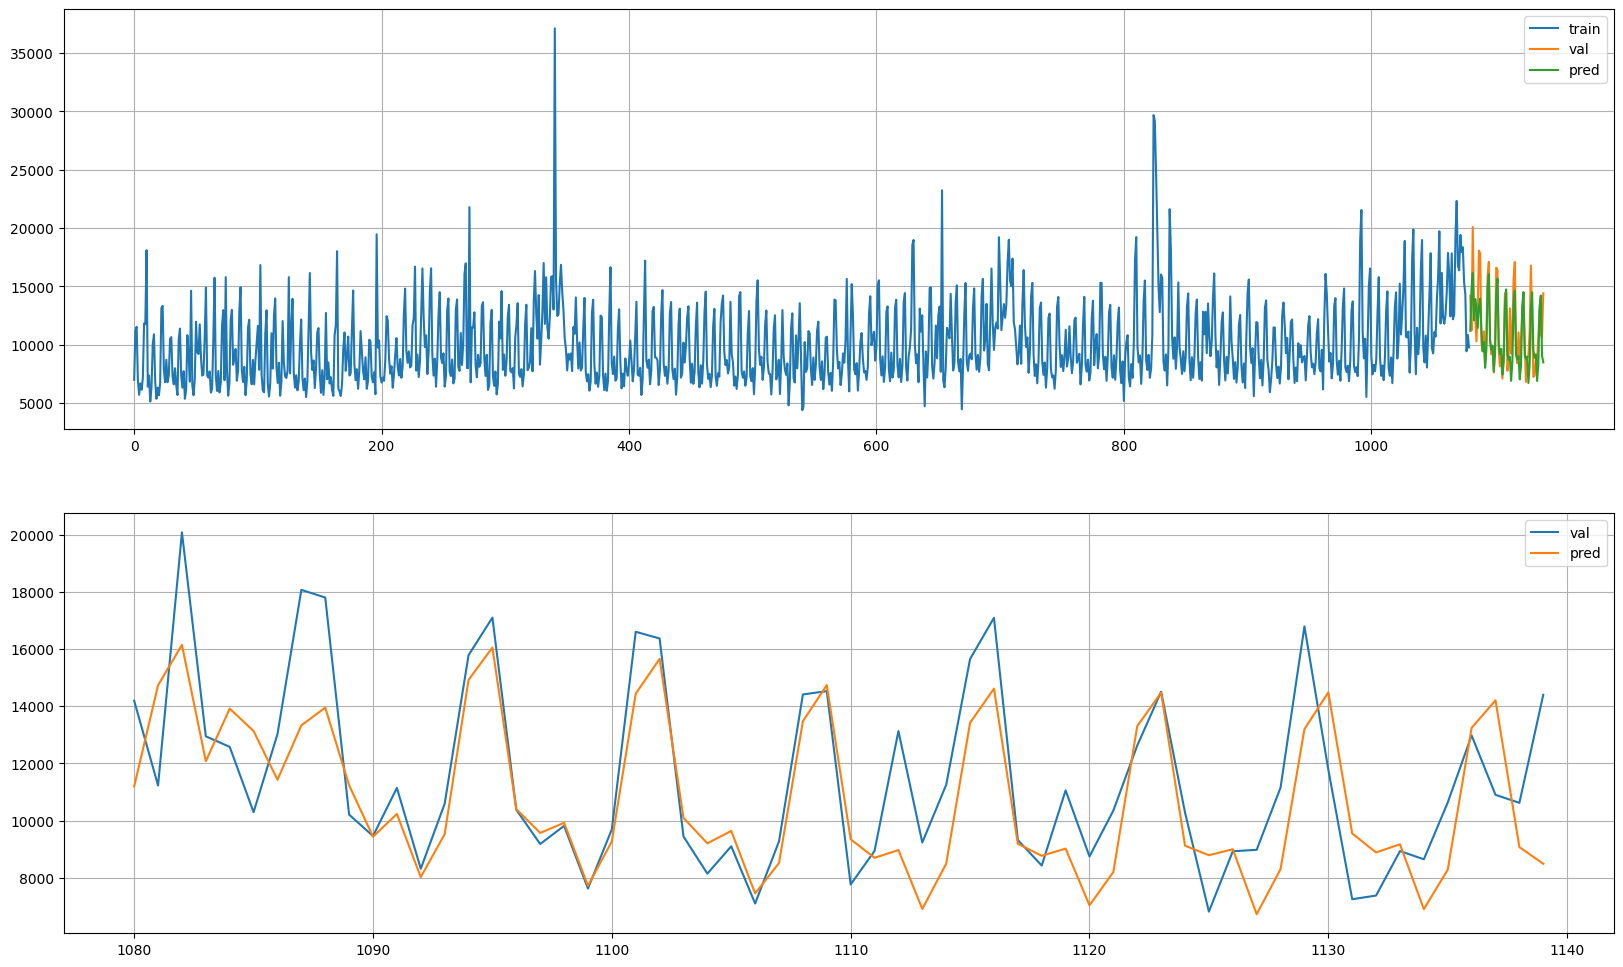

In [20]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [21]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1087, 7, 8), (60, 7, 8))

* **모델링**

In [22]:
clear_session()

_, ts, nfeat = x_train.shape

model_p42_lstm = Sequential([LSTM(16, input_shape = (ts, nfeat), return_sequences = True ),
                         LSTM(4, return_sequences = True),
                         Flatten(),
                         Dense(16, activation = 'relu'),
                         Dense(1)])
model_p42_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 16)               │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 4)                │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,417 (9.44 KB)

 Trainable params: 2,417 (9.44 KB)

 Non-trainable params: 0 (0.00 B)

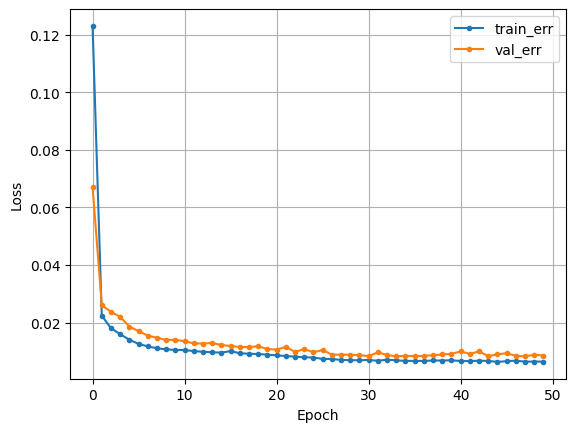

In [23]:
model_p42_lstm.compile(optimizer = 'adam', loss = 'mse')
hist = model_p42_lstm.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [24]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p42_lstm.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
MAE :  8.930927403767903
MAPE :  0.10142998376696434
R2 :  0.40311022052831547


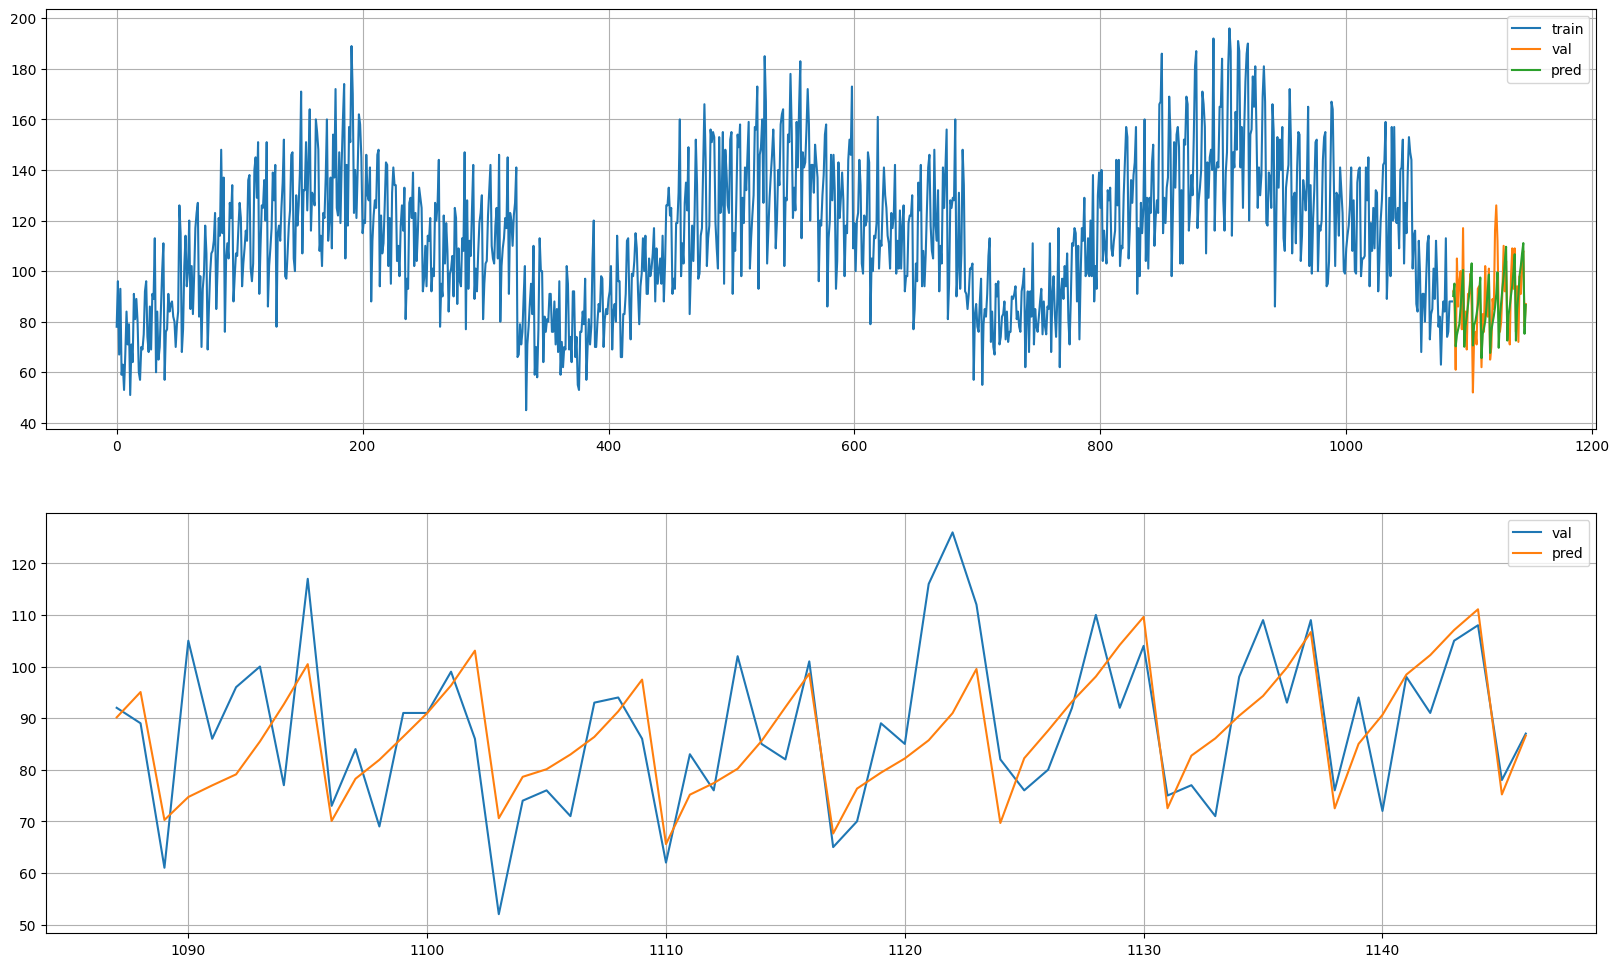

In [25]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [26]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1080, 7, 13), (60, 7, 13))

* **모델링**

In [27]:
clear_session()

_, ts, nfeat = x_train.shape

model_p3_cnn = Sequential([Conv1D(16, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Conv1D(8, 3, activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(16, activation='relu'),
                         Dense(1)])
model_p3_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 8)                │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,961 (7.66 KB)

 Trainable params: 1,961 (7.66 KB)

 Non-trainable params: 0 (0.00 B)

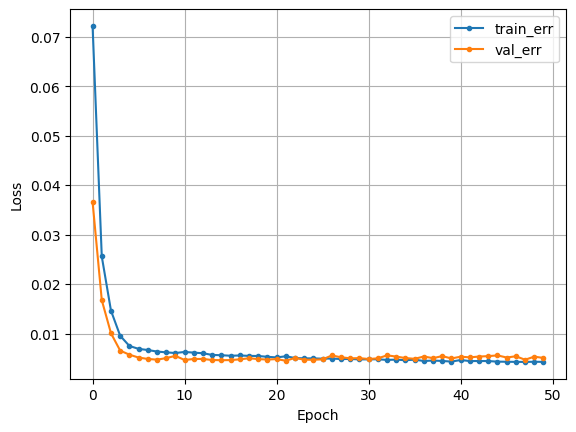

In [28]:
model_p3_cnn.compile(optimizer = 'adam', loss = 'mse')
hist = model_p3_cnn.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [29]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p3_cnn.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
MAE :  1673.0555338541667
MAPE :  0.14370616877114942
R2 :  0.6605682946859712


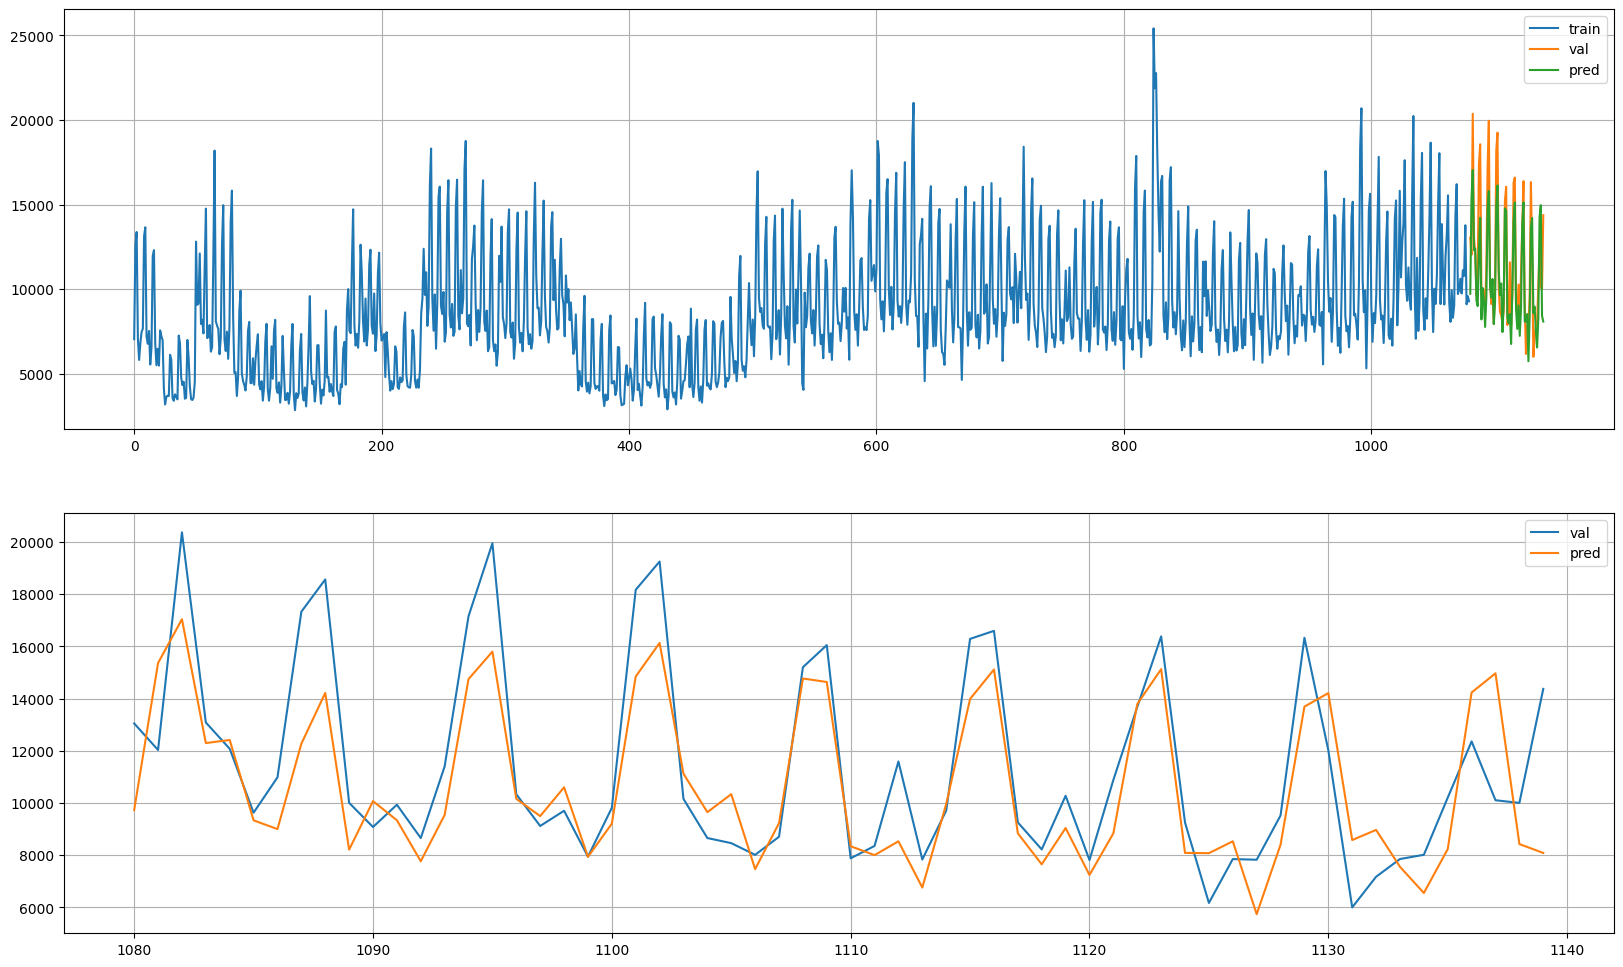

In [30]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [31]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1080, 7, 8), (60, 7, 8))

* **모델링**

In [32]:
clear_session()

_, ts, nfeat = x_train.shape

model_p12_cnn = Sequential([Conv1D(16, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Conv1D(8, 3, activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(16, activation='relu'),
                         Dense(1)])
model_p12_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 8)                │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,721 (6.72 KB)

 Trainable params: 1,721 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

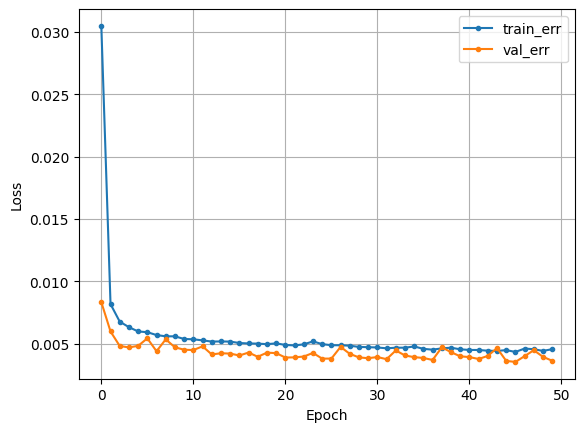

In [33]:
model_p12_cnn.compile(optimizer = 'adam', loss = 'mse')
hist = model_p12_cnn.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [34]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p12_cnn.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
MAE :  1672.3269205729166
MAPE :  0.14140440029420348
R2 :  0.5399273893188459


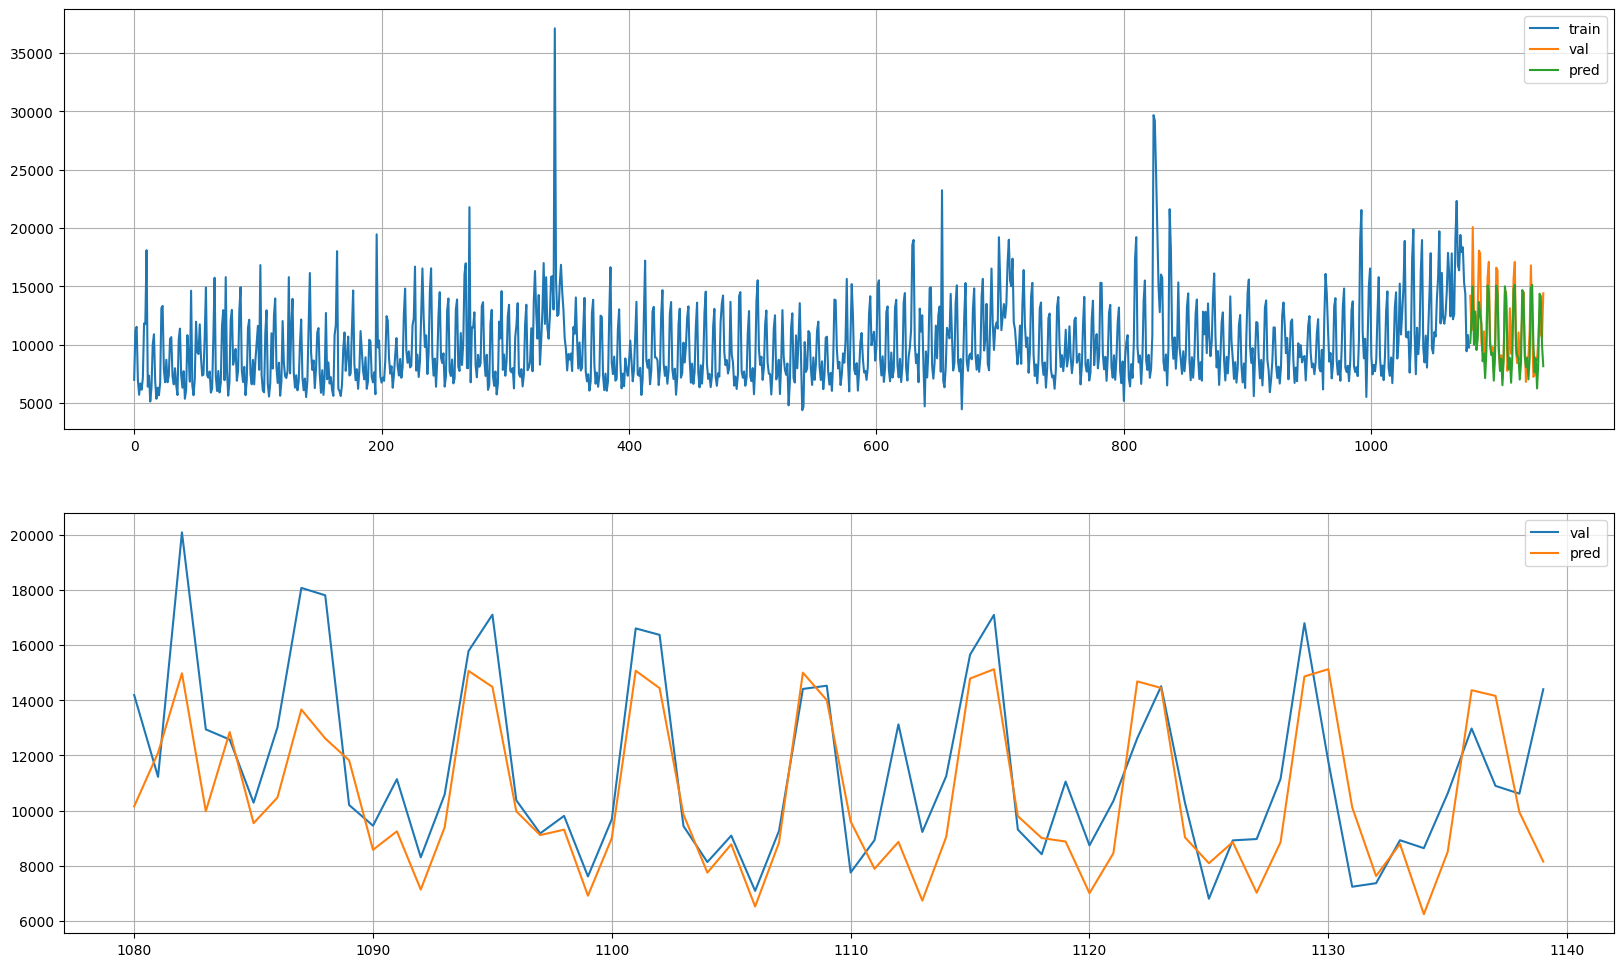

In [35]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [36]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = pre3d(product_42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1087, 7, 8), (60, 7, 8))

* **모델링**

In [37]:
clear_session()

_, ts, nfeat = x_train.shape

model_p42_cnn = Sequential([Conv1D(16, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Conv1D(8, 3, activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(16, activation='relu'),
                         Dense(1)])
model_p42_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 8)                │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,721 (6.72 KB)

 Trainable params: 1,721 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

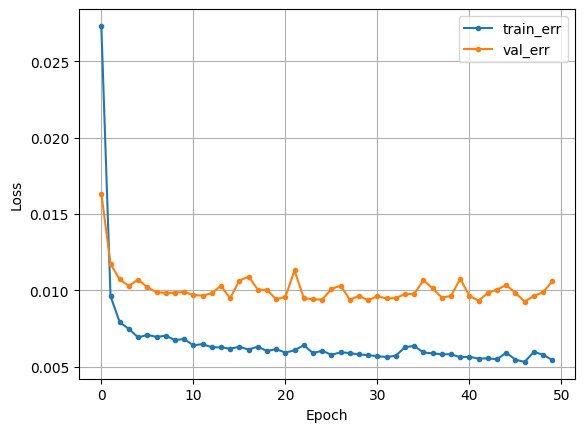

In [38]:
model_p42_cnn.compile(optimizer = 'adam', loss = 'mse')
hist = model_p42_cnn.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [39]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p42_cnn.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
MAE :  8.66480344136556
MAPE :  0.0971125460317595
R2 :  0.39104233916068665


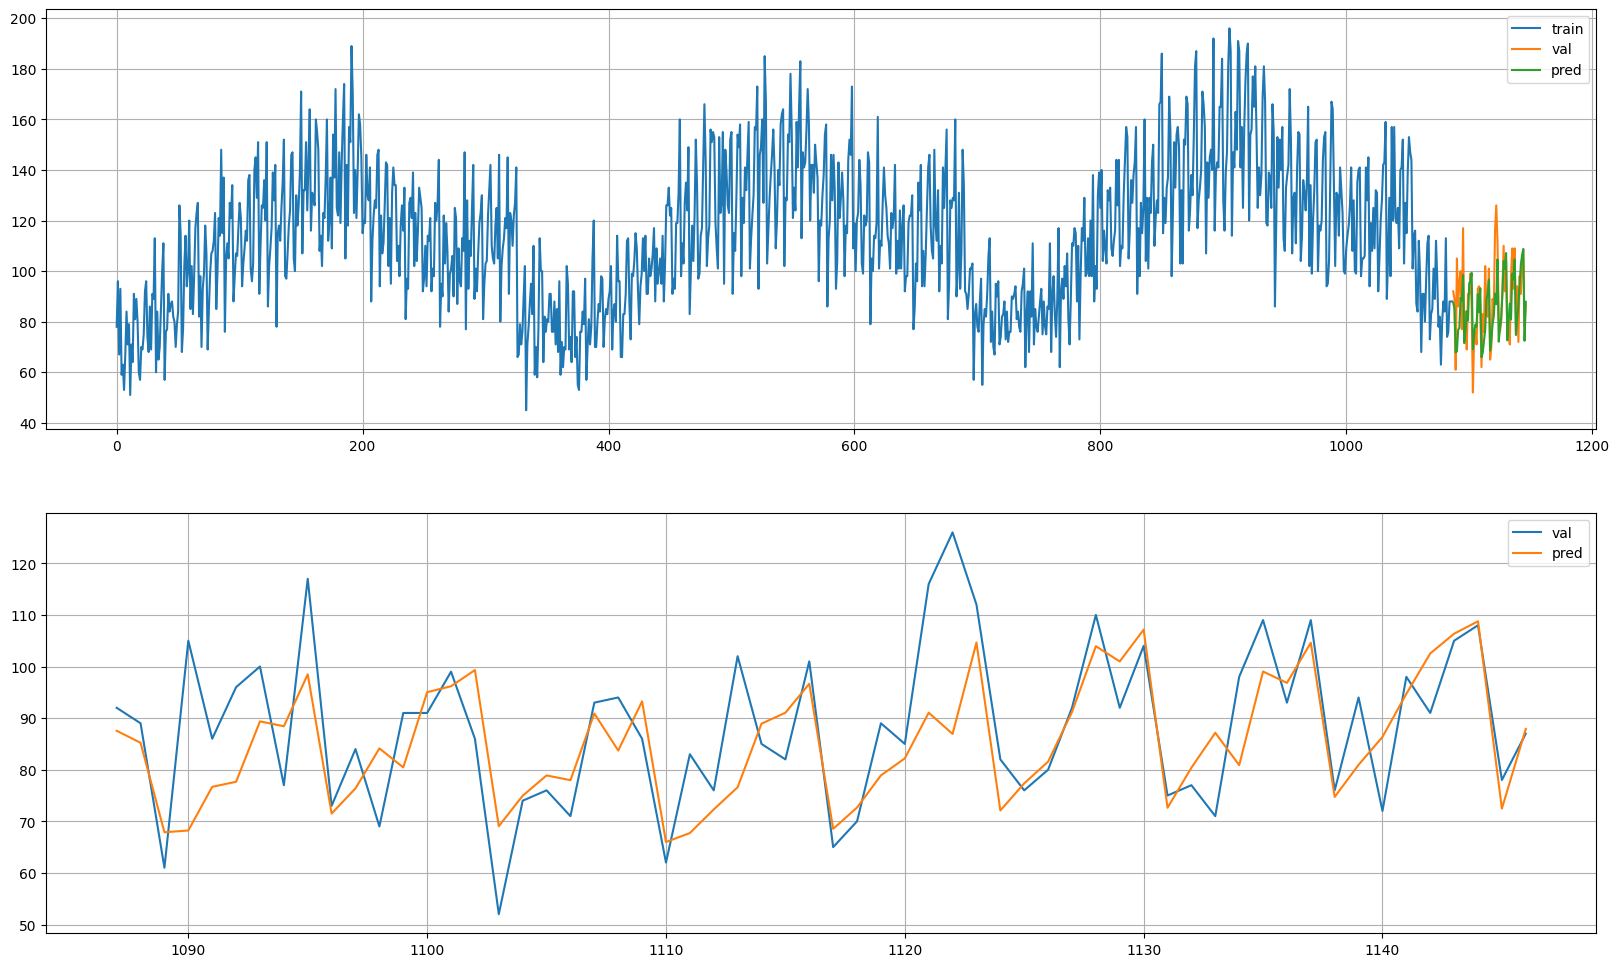

In [40]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트

## **(1) 파이프라인 함수 생성**

In [41]:
def prepare_dataset(sales, products, orders, stores, oil_price, Product_ID, Store_ID=44):
    # 기본 데이터 준비
    temp1 = sales.loc[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'] == Product_ID), ['Date', 'Qty']]
    temp2 = orders.loc[orders['Store_ID'] == Store_ID, ['Date', 'CustomerCount']]
    temp3 = pd.merge(temp1, temp2, on='Date', how='left')
    temp3 = pd.merge(temp3, oil_price, on='Date', how='left')

    # 'Qty'가 0인 행 삭제
    temp3 = temp3.drop(temp3[temp3['Qty'] == 0].index)

    # 'CustomerCount'와 'WTI_Price' 결측치를 선형 보간법으로 채우기
    temp3['CustomerCount'].interpolate(method='linear', inplace=True)
    temp3['WTI_Price'].interpolate(method='linear', inplace=True)

    # 결측치가 남아 있다면 뒤로 채우기 (선형 보간 후 여전히 결측치가 있으면)
    temp3['CustomerCount'].fillna(method='bfill', inplace=True)
    temp3['WTI_Price'].fillna(method='bfill', inplace=True)

    # 연, 월, 일, 요일 변환
    temp3['Date'] = pd.to_datetime(temp3['Date'])
    temp3['year'] = temp3['Date'].dt.year
    temp3['month'] = temp3['Date'].dt.month
    temp3['day'] = temp3['Date'].dt.day
    temp3['day_of_week'] = temp3['Date'].dt.dayofweek

    # y 생성
    leadTime = products.loc[products['Product_ID'] == Product_ID, 'LeadTime'].values[0]
    temp3['Qty_2days_later'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(subset=['Qty_2days_later'], inplace=True)

    return temp3

In [42]:
def feature_engineering_3(sales, products, orders, stores, oil_price, temp, Product_ID, Store_ID=44):

    temp['quarter'] = temp['Date'].dt.quarter  # 분기

    # 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'] == Product_ID, 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    category_sales = sales.loc[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index=False)['Qty'].sum()
    category_sales.columns = ['Date', 'Category_Qty']
    temp = temp.merge(category_sales, on='Date', how='left')

    # 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID'] == Store_ID, 'City'].values[0]
    Store_IDs = stores.loc[stores['City'] == City, 'Store_ID'].to_list()
    region_visitors = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index=False)['CustomerCount'].sum()
    region_visitors.columns = ['Date', 'City_CustCount']
    temp = temp.merge(region_visitors, on='Date', how='left')

    # 고객 수 대비 판매량 비율
    temp['qty_to_customer_ratio'] = temp.apply(
        lambda row: row['Qty'] / row['CustomerCount'] if row['CustomerCount'] > 0 else 0, axis=1
    )

    # 고객 수 이동 평균 및 차이
    temp['CustomerCount_MA_7'] = temp['CustomerCount'].rolling(window=7).mean()
    temp['CustomerCount_diff_vs_MA7'] = temp['CustomerCount'] - temp['CustomerCount_MA_7']

    # 판매량 차분 및 이동 평균 대비 차이
    temp['Qty_diff'] = temp['Qty'].diff()
    temp['Qty_diff_vs_MA'] = temp['Qty_diff'] - temp['Qty'].rolling(window=7).mean()

    # 주말 여부
    temp['is_weekend'] = temp['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # 결측치 처리
    temp.fillna(method='bfill', inplace=True)

    # 불필요한 변수 제거
    temp.drop(columns=['Date', 'year', 'day', 'WTI_Price'], inplace=True)

    return temp


In [43]:
def feature_engineering_12(sales, products, orders, stores, oil_price, temp, Product_ID):

    food_products = products[products['Category'] == 'Food']['Product_ID'] # 동일 카테고리
    food_sales_44 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin(food_products))]
    food_sales_44_agg = food_sales_44.groupby('Date')['Qty'].sum().reset_index()
    food_sales_44_agg.rename(columns={'Qty': 'Food_Sales'}, inplace=True)
    temp = temp.merge(food_sales_44_agg, on='Date', how='left')

    temp['quarter'] = temp['Date'].dt.quarter # 분기

    temp['qty_to_customer_ratio'] = temp['Qty'] / (temp['CustomerCount'] + 1e-5) # 고객 대비 판매량
    temp['is_weekend'] = temp['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0) # 주말 구분

    temp['Qty_MA_14'] = temp['Qty'].rolling(window=14).mean() # 14일 이동 평균 추가

    # 결측치 처리
    temp.fillna(method='bfill', inplace=True)

    # 불필요한 변수 제거
    temp.drop(columns=['Date', 'WTI_Price', 'year', 'day', 'month'], inplace=True)

    return temp

In [44]:
def feature_engineering_42(sales, products, orders, stores, oil_price, temp, Product_ID):

    temp['is_harvest'] = temp['month'].apply(lambda x: 1 if x in [6, 7, 8, 9, 10, 11] else 0) # 추수

    temp['qty_to_customer_ratio'] = temp['Qty'] / (temp['CustomerCount'] + 1e-5) # 고객 대비 판매량
    temp['is_weekend'] = temp['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0) # 주말 구분

    temp['Qty_MA_14'] = temp['Qty'].rolling(window=14).mean() # 14일 이동 평균

    # 고객 수 관련 변수
    temp['qty_to_customer_ratio'] = temp['Qty'] / (temp['CustomerCount'] + 1e-5)
    temp['customer_volatility'] = temp['CustomerCount'].rolling(window=7).std()

    # 결측치 처리
    temp.fillna(method='bfill', inplace=True)

    # 불필요한 변수 제거
    temp.drop(columns=['Date', 'WTI_Price', 'year', 'day', 'month'], inplace=True)

    return temp

In [45]:
def pre3d(data, timesteps, y_scale=False, target_col='Qty_2days_later'):

    x = data.drop(columns=[target_col], axis=1)
    y = data[target_col]

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 데이터 시계열화 (3차원 변환)
    x3, y3 = temporalize(x_scaled, y, timesteps)

    return x3, y3, scaler, y_min, y_max

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [46]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [47]:
temp3 = prepare_dataset(sales_test, products, orders_test, stores, oil_price_test, Product_ID=3)
product_3 = feature_engineering_3(sales_test, products, orders_test, stores, oil_price_test, temp3, 3)

temp12 = prepare_dataset(sales_test, products, orders_test, stores, oil_price_test, Product_ID=12)
product_12 = feature_engineering_12(sales_test, products, orders_test, stores, oil_price_test, temp12, 12)

temp42 = prepare_dataset(sales_test, products, orders_test, stores, oil_price_test, Product_ID=42)
product_42 = feature_engineering_42(sales_test, products, orders_test, stores, oil_price_test, temp42, 42)

In [57]:
product_3

,Qty,CustomerCount,month,day_of_week,Qty_2days_later,quarter,Category_Qty,City_CustCount,qty_to_customer_ratio,CustomerCount_MA_7,CustomerCount_diff_vs_MA7,Qty_diff,Qty_diff_vs_MA,is_weekend
0,10153.0,4146,3,2,10257.0,1,10388.0,42605,2.448866,4432.285714,-604.285714,-1235.0,-11681.000000,0
1,8918.0,3882,3,3,16991.0,1,9144.0,41595,2.297269,4432.285714,-604.285714,-1235.0,-11681.000000,0
2,10257.0,4483,3,4,18304.0,1,10627.0,44392,2.287977,4432.285714,-604.285714,1339.0,-11681.000000,0
3,16991.0,5382,3,5,8413.0,1,17537.0,51598,3.157005,4432.285714,-604.285714,6734.0,-11681.000000,1
4,18304.0,5423,3,6,8360.0,1,18665.0,51481,3.375254,4432.285714,-604.285714,1313.0,-11681.000000,1
5,8413.0,3882,3,0,8632.0,1,8633.0,40837,2.167182,4432.285714,-604.285714,-9891.0,-11681.000000,0
6,8360.0,3828,3,1,8816.0,1,8562.0,40127,2.183908,4432.285714,-604.285714,-53.0,-11681.000000,0
7,8632.0,4111,3,2,10087.0,1,8860.0,42499,2.099732,4427.285714,-316.285714,272.0,-11138.714286,0
8,8816.0,3560,3,3,15131.0,1,9057.0,36392,2.476404,4381.285714,-821.285714,184.0,-11212.142857,0
9,10087.0,4183,3,4,18556.0,1,10422.0,42278,2.411427,4338.428571,-155.428571,1271.0,-10100.857143,0


In [58]:
x, y, scaler, y_min, y_max = pre3d(product_3, timesteps=7, y_scale=True, target_col='Qty_2days_later')

print(x.shape)
print(y.shape)

(23, 7, 13)
(23,)


* 예측해보기

In [59]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_p3_lstm.predict(x)
pred_r = pred * (y_max - y_min) + y_min
y_r = y * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_r, pred_r))
print('MAPE : ',mean_absolute_percentage_error(y_r, pred_r))
print('R2 : ',r2_score(y_r, pred_r))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
MAE :  1963.7490871263587
MAPE :  0.1519714552960584
R2 :  0.5724677023414811


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절
        * 평균재고금액을 확인
    * 데이터는 test 셋을 이용
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 함
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [60]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [61]:
# y 스케일링 한 결과 되돌리기.
y_r = y * (y_max - y_min) + y_min
pred_r = pred * (y_max - y_min) + y_min

In [62]:
y_r.shape, pred_r.shape

((23,), (23, 1))

In [63]:
result = inv_simulator(y_r, pred_r, 377000, 8)

일평균 재고량     : 383230.762
일평균 재고 금액  : 3065846.096
일평균 재고회전율 : 0.031
기회손실 수량     : 0.0


In [64]:
result

,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,7104.0,385816,377000,13146,8816,0.0
1,10087.0,9552.0,387087,377000,12929,10087,0.0
2,15131.0,13146.0,390146,375015,9039,13146,0.0
3,18556.0,12929.0,387944,369388,16230,12929,0.0
4,8803.0,7054.0,378427,369624,16790,9039,0.0
5,8690.0,8618.0,385854,377164,8298,16230,0.0
6,9199.0,9414.0,393954,384755,2074,16790,0.0
7,8148.0,8462.0,393053,384905,5230,8298,0.0
8,11616.0,9829.0,386979,375363,15947,2074,0.0
9,16510.0,13135.0,380593,364083,22567,5230,0.0


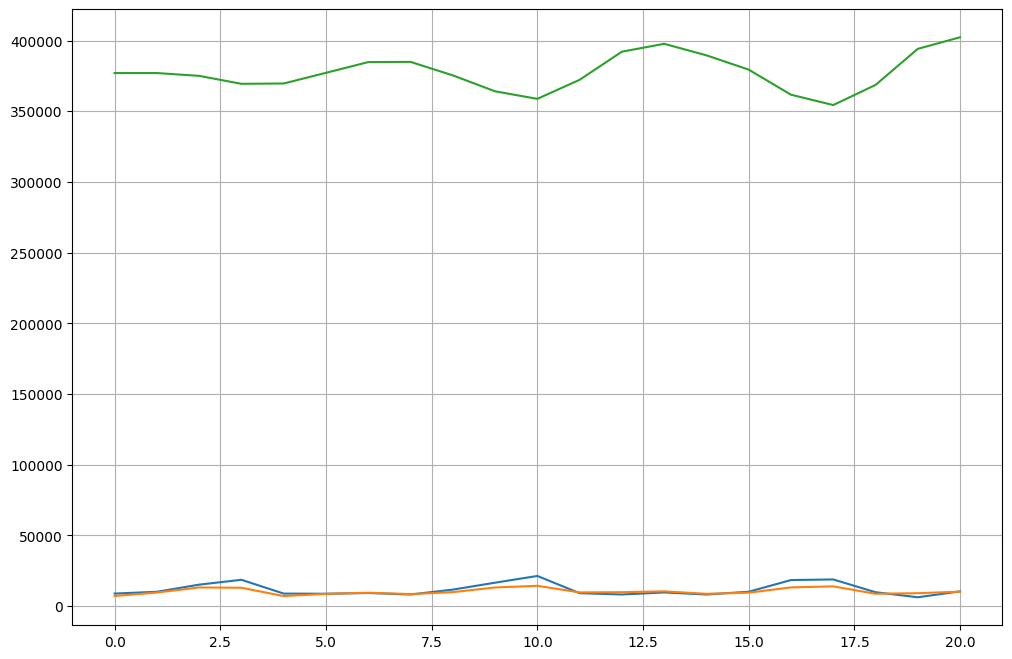

In [65]:
plt.figure(figsize = (12,8))
plt.plot(result['y'])
plt.plot(result['pred'])
plt.plot(result['close_stock'])

plt.grid()
plt.show()